# 1. Model description

In [12]:
using ReachabilityAnalysis, BenchmarkTools, Plots

In [13]:
# parameters of the model
const g = 9.81;           # gravity constant in m/s^2
const R = 0.1;            # radius of center mass in m
const l = 0.5;            # distance of motors to center mass in m
const Mrotor = 0.1;       # motor mass in kg
const M = 1.0;            # center mass in kg
const m = M + 4*Mrotor;   # total mass in kg
const mg = m*g;

# moments of inertia
const Jx = (2/5)*M*R^2 + 2*l^2*Mrotor;
const Jy = Jx;
const Jz = (2/5)*M*R^2 + 4*l^2*Mrotor;
const Cyzx = (Jy - Jz)/Jx;
const Czxy = (Jz - Jx)/Jy;
const Cxyz = 0.0; #(Jx - Jy)/Jz

# considering the control parameters as *parameters*
const u₁ = 1.0;
const u₂ = 0.0;
const u₃ = 0.0;

In [31]:
Jx, Jy, Jz

(0.054000000000000006, 0.054000000000000006, 0.10400000000000001)

In [32]:
Cyzx, Czxy, Cxyz

(-0.9259259259259258, 0.9259259259259258, 0.0)

In [50]:
@taylorize function quadrotor!(dx, x, params, t)
    # unwrap the variables and the controllers; the last three are the controllers
    x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀, x₁₁, x₁₂ = x

    # equations of the controllers
    F = (mg - 10*(x₃ - u₁)) + 3*x₆  # height control
    τϕ = -(x₇ - u₂) - x₁₀            # roll control
    τθ = -(x₈ - u₃) - x₁₁            # pitch control
    local τψ = 0.0                   # heading is uncontrolled
    #
    Tx = τϕ/Jx
    Ty = τθ/Jy
    Tz = τψ/Jz
    F_m = F/m

    # Some abbreviations
    sx7 = sin(x₇)
    cx7 = cos(x₇)
    sx8 = sin(x₈)
    cx8 = cos(x₈)
    sx9 = sin(x₉)
    cx9 = cos(x₉)
    #
    sx7sx9 = sx7*sx9
    sx7cx9 = sx7*cx9
    cx7sx9 = cx7*sx9
    cx7cx9 = cx7*cx9
    sx7cx8 = sx7*cx8
    cx7cx8 = cx7*cx8
    sx7_cx8 = sx7/cx8
    cx7_cx8 = cx7/cx8
    #
    x4cx8 = cx8*x₄
    #
    p11 = sx7_cx8*x₁₁
    p12 = cx7_cx8*x₁₂
    xdot9 = p11 + p12

    # differential equations for the quadrotor
    #
    dx[1] = (cx9*x4cx8 + (sx7cx9*sx8 - cx7sx9)*x₅) + (cx7cx9*sx8 + sx7sx9)*x₆
    dx[2] = (sx9*x4cx8 + (sx7sx9*sx8 + cx7cx9)*x₅) + (cx7sx9*sx8 - sx7cx9)*x₆
    dx[3] = (sx8*x₄ - sx7cx8*x₅) - cx7cx8*x₆
    dx[4] = (x₁₂*x₅ - x₁₁*x₆) - g*sx8
    dx[5] = (x₁₀*x₆ - x₁₂*x₄) + g*sx7cx8
    dx[6] = (x₁₁*x₄ - x₁₀*x₅) + (g*cx7cx8 - F_m)
    dx[7] = x₁₀ + sx8*xdot9
    dx[8] = cx7*x₁₁ - sx7*x₁₂
    dx[9] = xdot9
    dx[10] = Cyzx * (x₁₁ * x₁₂) + Tx
    dx[11] = Czxy * (x₁₀ * x₁₂) + Ty
    dx[12] = Cxyz * (x₁₀ * x₁₁) + Tz
    #
    return dx
end

# 2. Reachability settings

In [51]:
# initial conditions
Wpos = 0.5
Wvel = 0.4
X0c = zeros(12)
ΔX0 = [Wpos, Wpos, Wpos, Wvel, Wvel, Wvel, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
X0 = Hyperrectangle(X0c, ΔX0);

# 3. Results

In [52]:
prob = @ivp(x' = quadrotor!(x), dim: 12, x(0) ∈ X0);

sol = solve(prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));
solz = overapproximate(sol, Zonotope);

The task is to change the height from 0 [m] to 1 [m] within 5 [s]. A goal region [0.98, 1.02] of the
height x3 has to be reached within 5 [s] and the height has to stay below 1.4 for all times. After
1 [s] the height should stay above 0.9 [m].

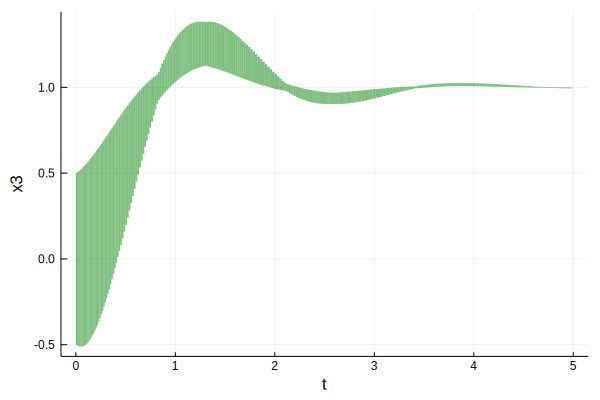

In [53]:
fig = plot()
plot!(fig, solz, vars=(0, 3), color=:green, lw=0.0, xlab="t", ylab="x3")

In [24]:
# x3 < 1.4 for all times
using LazySets: SingleEntryVector

v3 = SingleEntryVector(3, 12, 1.0)
@show ρ(v3, solz)
@assert ρ(v3, solz) < 1.4

ρ(v3, solz) = 1.3582571151221239


In [25]:
# check that the final state is in the goal region
@show ρ(v3, solz[end])
@show -ρ(-v3, solz[end])

ρ(v3, solz[end]) = 0.9983384155573501
-(ρ(-v3, solz[end])) = 0.9945928748059757


0.9945928748059757

In [94]:
# equivalent check
@assert set(project(solz[end], vars=(3))) ⊆ Interval(0.98, 1.02)

In [99]:
tf = tend(solz)
unsafe = HalfSpace(v3, 0.9) # unsafe: x3 <= 0.9
@assert all([isdisjoint(unsafe, set(R)) for R in solz(1.0 .. tf)])

In [88]:
# equivalent check
-ρ(-v3, Flowpipe(Vector(solz(1.0 .. tf)))) # should be > 0.9

0.9091207794101679

# 4. Parameter variations

## 4.1. Problem statement

In principle we could take parameter uncertainties in all the physical parameters of the model, these are

```julia
# parameters of the model
const g = 9.81;           # gravity constant in m/s^2
const R = 0.1;            # radius of center mass in m
const l = 0.5;            # distance of motors to center mass in m
const Mrotor = 0.1;       # motor mass in kg
const M = 1.0;            # center mass in kg
const m = M + 4*Mrotor;   # total mass in kg
const mg = m*g;
```

Noting that these parameters enter in the model through the moments of inertia, whose definition is recalled below, we propose to consider **variations in the moments of inertia** with respect to their nominal values.

```julia
# moments of inertia
const Jx = (2/5)*M*R^2 + 2*l^2*Mrotor;
const Jy = Jx;
const Jz = (2/5)*M*R^2 + 4*l^2*Mrotor;
const Cyzx = (Jy - Jz)/Jx;
const Czxy = (Jz - Jx)/Jy;
const Cxyz = 0.0; #(Jx - Jy)/Jz
```

Their "nominal" values are:

In [38]:
Jx, Jy, Jz

(0.054000000000000006, 0.054000000000000006, 0.10400000000000001)

In [39]:
Cyzx, Czxy, Cxyz

(-0.9259259259259258, 0.9259259259259258, 0.0)

**Question.** Assuming that the moments of inertia have variations of $\chi \%$ with respect to their nominal values, which is the greatest $\chi$ for which the stabilization property holds?

---

## 4.2. Results

In the following approach, we add 6 extra variables corresponding to the parameters with uncetainty; such variables have zero dynamics and the uncertainty is given in their initial condition, as an interval.

In [41]:
Jx0 = Jx
Jy0 = Jy
Jz0 = Jz;

In [40]:
Cyzx0 = Cyzx
Czxy0 = Czxy
Cxyz0 = Cxyz;

In [44]:
@taylorize function quadrotor_modif!(dx, x, params, t)
    # unwrap the variables and the controllers; the last three are the controllers
    x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀, x₁₁, x₁₂, jx, jy, jz, cyzx, czxy, cxyz = x

    # equations of the controllers
    F = (mg - 10*(x₃ - u₁)) + 3*x₆  # height control
    τϕ = -(x₇ - u₂) - x₁₀            # roll control
    τθ = -(x₈ - u₃) - x₁₁            # pitch control
    local τψ = 0.0                   # heading is uncontrolled
    #
    Tx = τϕ/jx
    Ty = τθ/jy
    Tz = τψ/jz
    F_m = F/m

    # Some abbreviations
    sx7 = sin(x₇)
    cx7 = cos(x₇)
    sx8 = sin(x₈)
    cx8 = cos(x₈)
    sx9 = sin(x₉)
    cx9 = cos(x₉)
    #
    sx7sx9 = sx7*sx9
    sx7cx9 = sx7*cx9
    cx7sx9 = cx7*sx9
    cx7cx9 = cx7*cx9
    sx7cx8 = sx7*cx8
    cx7cx8 = cx7*cx8
    sx7_cx8 = sx7/cx8
    cx7_cx8 = cx7/cx8
    #
    x4cx8 = cx8*x₄
    #
    p11 = sx7_cx8*x₁₁
    p12 = cx7_cx8*x₁₂
    xdot9 = p11 + p12

    # differential equations for the quadrotor
    #
    dx[1] = (cx9*x4cx8 + (sx7cx9*sx8 - cx7sx9)*x₅) + (cx7cx9*sx8 + sx7sx9)*x₆
    dx[2] = (sx9*x4cx8 + (sx7sx9*sx8 + cx7cx9)*x₅) + (cx7sx9*sx8 - sx7cx9)*x₆
    dx[3] = (sx8*x₄ - sx7cx8*x₅) - cx7cx8*x₆
    dx[4] = (x₁₂*x₅ - x₁₁*x₆) - g*sx8
    dx[5] = (x₁₀*x₆ - x₁₂*x₄) + g*sx7cx8
    dx[6] = (x₁₁*x₄ - x₁₀*x₅) + (g*cx7cx8 - F_m)
    dx[7] = x₁₀ + sx8*xdot9
    dx[8] = cx7*x₁₁ - sx7*x₁₂
    dx[9] = xdot9
    dx[10] = cyzx * (x₁₁ * x₁₂) + Tx
    dx[11] = czxy * (x₁₀ * x₁₂) + Ty
    dx[12] = cxyz * (x₁₀ * x₁₁) + Tz
    # parameters
    dx[13] = zero(x₁)
    dx[14] = zero(x₁)
    dx[15] = zero(x₁)
    dx[16] = zero(x₁) 
    dx[17] = zero(x₁)
    dx[18] = zero(x₁)
    #
    return dx
end

### Case without parameter variation

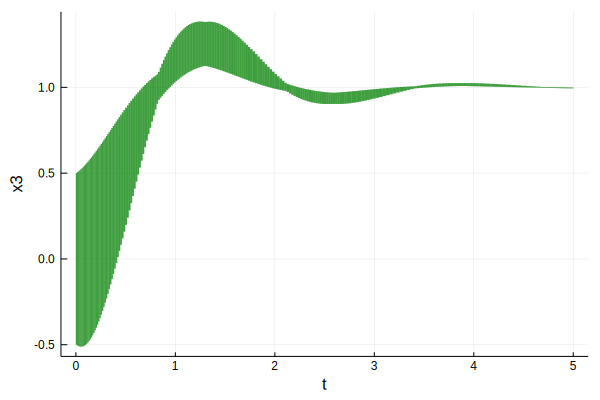

In [57]:
# initial conditions
Wpos = 0.5
Wvel = 0.4

params_center = [Jx0, Jy0, Jz0, Cyzx0, Czxy0, Cxyz0]
X0c = vcat(zeros(12), params_center)

params_radius = [0, 0, 0, 0, 0, 0]
ΔX0 = vcat([Wpos, Wpos, Wpos, Wvel, Wvel, Wvel, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], params_radius)

X0 = Hyperrectangle(X0c, ΔX0);

prob = @ivp(x' = quadrotor_modif!(x), dim: 18, x(0) ∈ X0);

sol = solve(prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));
solz = overapproximate(sol, Zonotope);

plot!(deepcopy(fig), solz, vars=(0, 3), color=:green, lw=0.0, xlab="t", ylab="x3")

### Case with $\chi= 1\%$ variation

In [59]:
params_center

6-element Array{Float64,1}:
  0.054000000000000006
  0.054000000000000006
  0.10400000000000001
 -0.9259259259259258
  0.9259259259259258
  0.0

In [72]:
X0

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054000000000000006, 0.054000000000000006, 0.10400000000000001, -0.9259259259259258, 0.9259259259259258, 0.0], [0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0027000000000000006, 0.0027000000000000006, 0.005200000000000001, 0.046296296296296294, 0.046296296296296294, 0.0])

In [73]:
# initial conditions
Wpos = 0.5
Wvel = 0.4

params_center = [Jx0, Jy0, Jz0, Cyzx0, Czxy0, Cxyz0]
X0c = vcat(zeros(12), params_center)

params_radius = 0.05 .* abs.(params_center)
ΔX0 = vcat([Wpos, Wpos, Wpos, Wvel, Wvel, Wvel, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], params_radius)

X0 = Hyperrectangle(X0c, ΔX0);

prob = @ivp(x' = quadrotor_modif!(x), dim: 18, x(0) ∈ X0);

sol = solve(prob, tspan=(0.0, 5.0), TMJets(abs_tol=1e-7, orderT=5, orderQ=1));
solz = overapproximate(sol, Zonotope);

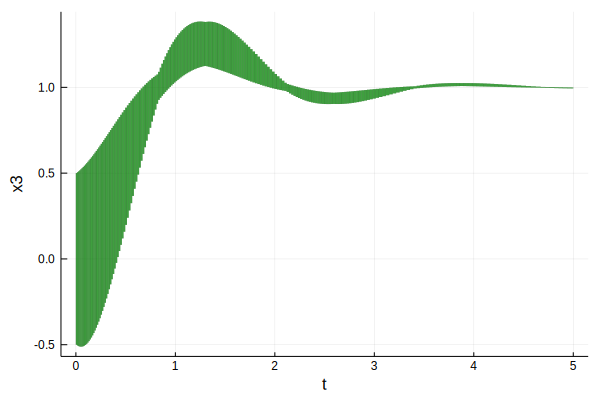

In [74]:
plot!(deepcopy(fig), solz, vars=(0, 3), color=:green, lw=0.1, xlab="t", ylab="x3")